In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig
)
from rl_analysis.io.df import dlight_exclude
from sklearn import model_selection
from sklearn import linear_model

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Helper functions

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_common"]
regression_cfg = analysis_config["dlight_regression"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

In [7]:
syllable_stats = toml.load(
    os.path.join(proc_dirs["dlight"], "syllable_stats_photometry_offline.toml")
)

# Loading in features for correlation

In [8]:
partition_cols = ["area", "mouse_id", "uuid"]

In [9]:
feature_df = pd.read_parquet(features_save_file)
rle_df = pd.read_parquet(rle_save_file)

In [10]:
feature_df[partition_cols] = feature_df[partition_cols].astype("str")
rle_df[partition_cols] = rle_df[partition_cols].astype("str")

In [11]:
feature_df = feature_df.loc[feature_df["duration"] > 0.3].copy()
feature_df = dlight_exclude(
    feature_df, exclude_3s=False, syllable_key="syllable", **dlight_cfg
)
rle_df = rle_df.loc[rle_df["uuid"].isin(feature_df["uuid"])].copy()

In [12]:
try:
    feature_df = feature_df.set_index("window_tup", append=True)
except KeyError:
    pass

In [13]:
wins = feature_df.index.get_level_values(-1).unique()

In [14]:
idx = pd.IndexSlice

In [15]:
use_scalars = [
    "velocity_2d_mm_mean",
    "acceleration_2d_mm_mean",
    "velocity_angle_mean",
    "velocity_height_mean",
    "jerk_2d_mm_mean",
]

In [16]:
dfs = []
for _idx in tqdm(wins):
    use_vals = feature_df.loc[
        idx[:, _idx],
        lagged_cfg["use_neural_features"] + ["signal_reref_dff_z_idxmax"] + use_scalars,
    ]
    use_vals.columns = [f"{_}_{_idx}" for _ in use_vals.columns]
    use_vals.index = use_vals.index.droplevel(-1)
    dfs.append(use_vals)

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
meta_cols = feature_df.columns.difference(feature_df.filter(regex="dff").columns)

In [18]:
meta_df = feature_df[meta_cols].loc[idx[:, _idx], :]
meta_df.index = meta_df.index.droplevel(-1)

In [19]:
feature_df = pd.concat(dfs, axis=1).join(meta_df)

In [20]:
syllable_classes = toml.load(os.path.join(proc_dirs["closed_loop_behavior"], "behavior_classes.toml"))
syllable_map = {}

for k, v in syllable_classes.items():
    for _syllable in v:
        syllable_map[_syllable] = k

In [21]:
feature_df["syllable_class"] = feature_df["syllable"].map(syllable_map)

In [22]:
use_feature = "signal_reref_dff_z_max_(0.0, 0.3)"

In [23]:
peak_means = (
    feature_df.groupby(["area", "mouse_id", "uuid", "syllable", "syllable_class"])[
        use_feature
    ]
    .mean()
    .groupby(["area", "syllable", "syllable_class"])
    .median()
)

In [24]:
plt_order = (
    peak_means.groupby(["area", "syllable_class"]).mean().loc["dls"].sort_values().index
)

In [25]:
setup_plotting_env()

In [27]:
from collections import defaultdict

In [28]:
shuffle_accs = defaultdict(list)
obs_accs = defaultdict(list)

In [29]:
nshuffles = 1000

In [30]:
for _area in ["dls", "dms"]:
    features = peak_means.loc[_area].reset_index()
    x = features[use_feature].values
    y = pd.factorize(features["syllable_class"])[0]

    splits = model_selection.RepeatedKFold(n_splits=5, n_repeats=5)
    clf = linear_model.LogisticRegression(warm_start=False)

    rng = np.random.default_rng(0)

    for _shuffle in tqdm(range(nshuffles)):
        accs = []
        for train_idx, test_idx in splits.split(x):
            train_x, train_y = x[train_idx], y[train_idx]
            test_x, test_y = x[test_idx], y[test_idx]
            clf.fit(train_x.reshape(-1, 1), train_y)
            predicted_class = clf.predict(test_x.reshape(-1, 1))
            accs.append(np.mean(predicted_class == rng.permutation(test_y)))
        shuffle_accs[_area].append(np.mean(accs))

    for train_idx, test_idx in splits.split(x):
        train_x, train_y = x[train_idx], y[train_idx]
        test_x, test_y = x[test_idx], y[test_idx]
        clf.fit(train_x.reshape(-1, 1), train_y)
        predicted_class = clf.predict(test_x.reshape(-1, 1))
        obs_accs[_area].append(np.mean(predicted_class == test_y))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
setup_plotting_env()

In [32]:
colors = sns.color_palette()

In [33]:
features = peak_means.loc[_area].reset_index()
x = features[use_feature].values

In [34]:
stats = {}
for _area in ["dls", "dms"]:
    stats[_area] = {}
    stats[_area]["p"] = (
        np.array(shuffle_accs[_area]) > np.mean(obs_accs[_area])
    ).mean()
    stats[_area]["percent_accuracy"] = np.mean(obs_accs[_area]) * 1e2
    stats[_area]["n"] = len(peak_means.loc[_area])
    stats[_area]["n_definition"] = "syllable averages"
    stats[_area]["n_splits"] = len(obs_accs[_area])

In [35]:
rng = np.random.default_rng(4)

In [36]:
random_order = rng.permutation(np.arange(len(syllable_classes)))

In [37]:
random_order = {k: v for k, v in zip(syllable_classes.keys(), random_order)}
random_order = {k: v for k, v in sorted(random_order.items(), key=lambda item: item[1])}

In [38]:
setup_plotting_env()

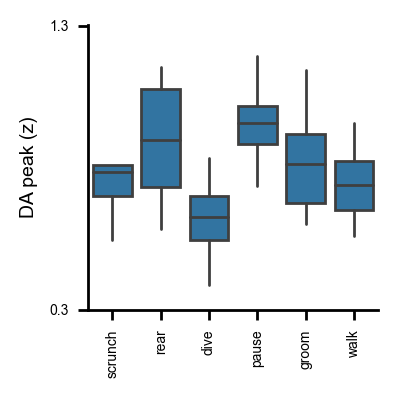

In [39]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(2, 2),
    sharey="col",
    sharex="col",
)
sns.boxplot(
    data=peak_means.loc["dls"].reset_index(),
    x="syllable_class",
    order=random_order,
    showfliers=False,
    showcaps=False,
    color=colors[0],
    y=use_feature,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.tick_params("x", rotation=90)
ax.set_ylabel("DA peak (z)")
clean_ticks(ax, "y", precision=1, dtype=float)

fig.tight_layout()
sns.despine()
savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], "dlight_class_analysis"),
    bbox_inches="tight",
)